##  **First atempt on a ML Model for IQA on BRSet**
### **Instituto de Matemática e Estatística da Universidade de São Paulo (IME-USP)**
### Rodrigo de Castro Michelassi
### 06.03.24

### Importing packages and libraries

In [1]:
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import AUC, Recall, Precision, BinaryAccuracy

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


### Importing images data generators

> Now we are trying to get a generator specific for training, testing and validating

In [9]:
# FUNCTION: IMPORT IMAGES FROM DATASET
# class_mode='categorical' for multiple classes
def import_images(train_dir, test_dir, val_dir):
    datagen_train = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        # width_shift_range=0.2,
        # height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )

    datagen_val_test = ImageDataGenerator(
        rescale=1./255,
    )

    train_generator = datagen_train.flow_from_directory(
        train_dir,
        batch_size=128,
        target_size=(224, 224),
        class_mode='binary',
        shuffle=True,
    )

    validation_generator = datagen_val_test.flow_from_directory(
        val_dir,
        batch_size=128,
        target_size=(224, 224),
        class_mode='binary',
        shuffle=True,
    )

    test_generator = datagen_val_test.flow_from_directory(
        test_dir,
        batch_size=128,
        target_size=(224, 224),
        class_mode='binary',
        shuffle=False,  # Normalmente não precisamos embaralhar o conjunto de teste
    )

    # plot image to check data augmentation
    fig, ax = plt.subplots(nrows=1, ncols=5)

    for i in range(5):
        image = next(train_generator)[0][0]  

        ax[i].imshow(image)
        ax[i].axis('off')
    plt.show()

    return train_generator, test_generator, validation_generator


### Get the size of each generator

In [3]:
# FUNCTION: PRINT GENERATOR SIZE BY CLASS
def check_generators_size(generator):
    class_indices = generator.class_indices
    print("Mapeamento de classes:", class_indices)

    index_to_class = {v: k for k, v in class_indices.items()}

    class_counts = {class_name: 0 for class_name in class_indices.keys()}
    for label in generator.labels:
        class_name = index_to_class[label]
        class_counts[class_name] += 1

    print("Contagem de imagens por classe:", class_counts)

### Defining the model and training

In [4]:
# FUNCTION: MODEL FOR TRAINING
def train_model(num_classes, epochs, train_generator, validation_generator):
    # Load VGG16 Pre Trained CNN
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the base_model layers so they can not be changed
    for layer in base_model.layers:
        layer.trainable = False

    # Building the model and fine tuning
    model = Sequential([
        base_model,
        Flatten(),
        tf.keras.layers.Dropout(0.5),
        Dense(256, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    # Define model parameters
    # for multilabel model: use categorical_crossentropy loss
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
        loss='binary_crossentropy', 
        metrics=[
            'accuracy', 
            AUC(name='auc', curve='PR'), 
            Precision(name='precision', class_id=1),
            Recall(name='recall', class_id=1), 
            BinaryAccuracy(name='binary_accuracy', threshold=0.85)
        ]
    )

    # Define checkpoint, fit the model and save weights
    checkpoint_filepath = '/Users/rodrigomichelassi/Documents/USP/IQA-Motorola/algorithms/model/v2/weights/.'

    # define the callback to save weights
    model_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath, 
        save_weights_only=True, 
        monitor='val_accuracy', 
        save_best_only=True, 
        mode='max'
    )

    # define the training model
    history = model.fit_generator(
        train_generator, 
        epochs=epochs,
        validation_data=validation_generator,
        callbacks=[model_callback]
    )

    # model.load_weights(checkpoint_filepath)
    return history, model

### Plotting graphs Epochs $\times$ Metric

In [5]:
# FUNCTION: PLOT GRAPH AND SAVE 
def plot_metric_epochs(train_data, val_data, train_label, val_label, x_label, y_label, title, file_name):
    plt.plot(train_data, color='royalblue', label=train_label)
    plt.plot(val_data, color='cornflowerblue', label=val_label)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc='upper right')
    plt.savefig("./graphs/" + file_name + ".png")
    plt.close()

def call_plot(history):
    plot_metric_epochs(history.history['loss'], history.history['val_loss'], "Training Loss", "Validation Loss", "Epochs", "Categorical Cross-Entropy Loss", "Loss Comparison", "LossG1")
    plot_metric_epochs(history.history['accuracy'], history.history['val_accuracy'], "Training Accuracy", "Validation Accuracy", "Epochs", "Accuracy", "Accuracy Comparison", "AccuracyG1")
    plot_metric_epochs(history.history['auc'], history.history['val_auc'], "Training AUC", "Validation AUC", "Epochs", "AUC Value", "AUC Comparison", "AUC Graph 1")
    plot_metric_epochs(history.history['precision'], history.history['val_precision'], "Training Precision", "Validation Precision", "Epochs", "Precision Value", "Precision Comparison", "PrecisionG1")
    plot_metric_epochs(history.history['recall'], history.history['val_recall'], "Training Recall", "Validation Recall", "Epochs", "Recall Value", "Recall Comparison", "RecallG1")

### Plot confusion matrix and classification report

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusão normalizada")
    else:
        print('Matriz de confusão, sem normalização')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Label verdadeiro')
    plt.xlabel('Label previsto')


def confusion_matrix_and_report(model, val_generator, batch_size):
    # use num_of_test_samples // batch_size + 1
    Y_pred = model.predict_generator(val_generator, 3254 // batch_size+1)
    y_pred = np.argmax(Y_pred, axis=1)

    cm = confusion_matrix(val_generator.classes, y_pred)
    print('Confusion Matrix')
    print(confusion_matrix(val_generator.classes, y_pred))
    print('Classification Report')
    target_names = ['Inadequate', 'Adequate']
    print(classification_report(val_generator.classes, y_pred, target_names=target_names))

    plt.figure(figsize=(10, 7))
    plot_confusion_matrix(cm, classes=target_names, title='Confusion Matrix')
    plt.savefig("./graphs/confusion_matrix.png")
    plt.show()

### Test the model efficiency

In [ ]:
def test_model(model, test_generator):
    test_loss, test_acc = model.evaluate(test_generator)
    return test_loss, test_acc

### Main execution of the code

Num GPUs Available:  0
Importando imagens: 
Found 10409 images belonging to 2 classes.
Found 2603 images belonging to 2 classes.
Found 3254 images belonging to 2 classes.


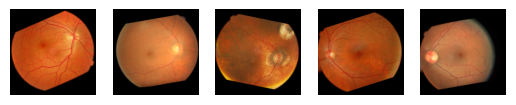


Dados gerador de treino:
Mapeamento de classes: {'0': 0, '1': 1}
Contagem de imagens por classe: {'0': 1275, '1': 9134}

Dados gerador de validação:
Mapeamento de classes: {'0': 0, '1': 1}
Contagem de imagens por classe: {'0': 413, '1': 2841}

Dados gerador de teste:
Mapeamento de classes: {'0': 0, '1': 1}
Contagem de imagens por classe: {'0': 299, '1': 2304}


In [10]:
def main():
    train_path = "/Users/rodrigomichelassi/Documents/USP/IQA-Motorola/data/brset/physionet.org/files/brazilian-ophthalmological/1.0.0/fundus_photos/train"
    test_path = "/Users/rodrigomichelassi/Documents/USP/IQA-Motorola/data/brset/physionet.org/files/brazilian-ophthalmological/1.0.0/fundus_photos/test"
    val_path = "/Users/rodrigomichelassi/Documents/USP/IQA-Motorola/data/brset/physionet.org/files/brazilian-ophthalmological/1.0.0/fundus_photos/validation"
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

    print("Importando imagens: ")
    train_generator, val_generator, test_generator = import_images(train_path, test_path, val_path)

    print("\nDados gerador de treino:")
    check_generators_size(train_generator)

    print("\nDados gerador de validação:")
    check_generators_size(val_generator)

    print("\nDados gerador de teste:")
    check_generators_size(test_generator)

    num_classes = 2
    epochs = 25
    history, model = train_model(num_classes, epochs, train_generator, val_generator)

    call_plot(history=history)

    confusion_matrix_and_report(model, val_generator, 128)

    test_loss, test_acc = test_model(model=model, test_generator=test_generator)
    print("Resultados do teste:")
    print("Loss: {}".format(test_loss), "Acurácia: {}".format(test_acc))
main()